In [16]:
import numpy as np
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import pandas as pd
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
sns.set_style('darkgrid')
import os
from image_utils import load_images_from_path,show_modification

Clustering

In [17]:
from clustering_utils import umap,tSNE,compute_most_represented_class_per_cluster,substitute_classes_labels
from cVAE_architecture import cVAE, loss_vae
from cVAE_train_utils import train_cVAE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 128

In [18]:
from sklearn.manifold import TSNE
def tSNE(z, latent_space, clustering_labels, true_labels=None, cmap='viridis', aff_true_labels=True,data=None):
    # t-SNE projection
    tSNE_2d = TSNE(n_components=2) 
    proj_2d = tSNE_2d.fit_transform(z)  
    
    params = {'backend': 'Agg', "font.family": "calibri"}  # extend as needed
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"] = 1.25
    fig = plt.figure()
    fig, ax = plt.subplots(layout="constrained")
    scatter = ax.scatter(x=proj_2d[:, 0], y=proj_2d[:, 1], s=15, c=clustering_labels, alpha=0.8, cmap=cmap)
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes", fontsize=5)
    
    ax.set_facecolor("white")
    ax.add_artist(legend1)
    plt.title(f'Prediction (latent space={latent_space})', fontsize=20)
    plt.xlabel('tSNE_1', fontsize=24)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('tSNE_2', fontsize=24)
    plt.savefig('./Results/tSNE_prediction_Zdim'+str(latent_space)+str(data)+'.png')
    plt.show()

    # Display the true labels if aff_true_labels is True
    if aff_true_labels:
        fig, ax = plt.subplots(layout="constrained")
        
        scatter = ax.scatter(x=proj_2d[:, 0], y=proj_2d[:, 1], s=15, c=true_labels, alpha=0.8, cmap="winter")
        legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes", fontsize=5)
        
        ax.set_facecolor("white")
        ax.add_artist(legend1)
        plt.title(f'True Label (latent space={latent_space})', fontsize=20)
        plt.xlabel('tSNE_1', fontsize=24)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylabel('tSNE_2', fontsize=24)
        plt.savefig('./Results/tSNE_gt_Zdim'+str(latent_space)+str(data)+'.png')
        plt.show()
        
        

In [19]:
def pourcentage_label(label,l,y):
    count_0 = 0
    count_1 = 0
    for i in range (len(y)):
        if l[i]==label and y[i]==0:
            count_0+=1
        if l[i]==label and y[i]==1:
            count_1+=1
    
    count_0 = (count_0*100)/(np.sum(l==label))
    count_1 = (count_1*100)/(np.sum(l==label))
    print(f"For label {label}:")
    print(f"number of cells of the cluster: {np.sum(l==label)}")
    print(f"Percentage of occurrences of wild cells: {count_0:.2f}%")
    print(f"Percentage of occurrences of mutation cells: {count_1:.2f}%")
    return count_0,count_1,np.sum(l==label)         

def pourcentage_cells(labels,y):
    print("")
    print("number of cells Wild = ",np.sum(y==0))
    print("number of Mutation cells  = ",np.sum(y==1))
    for label in set(labels):
        pourcentage_label(label,labels,y)

## Wild vs PIK3CA

In [20]:
# Define a transform to preprocess the data
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(root='cropped72', transform=transform)

train_proportion = 0.8
test_proportion = 1 - train_proportion

# Calculate the number of samples for each split
total_samples = len(dataset)
train_samples = int(train_proportion * total_samples)
test_samples = total_samples - train_samples

# Use random_split to create train and test datasets with the calculated proportions
train_dataset, test_dataset = random_split(dataset, [train_samples, test_samples])

# Create DataLoader instances to load batches during training and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: torch.Size([3592, 1, 72, 72])
Y_train shape: torch.Size([3592])
X_test shape: torch.Size([898, 1, 72, 72])
Y_test shape: torch.Size([898])


Wild type


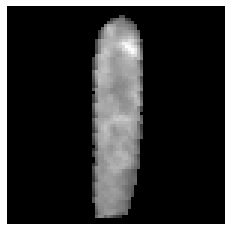

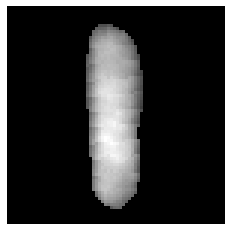

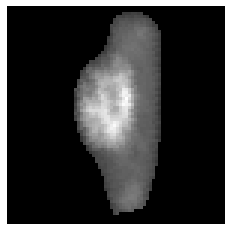

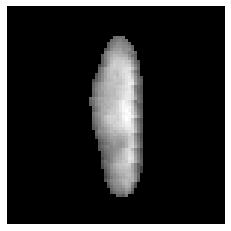

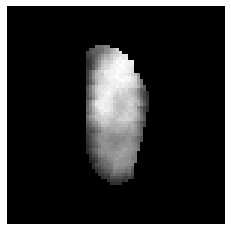

In [21]:
print("Wild type")
l1 = [X_train[55*i][0] for i in range (5)]
for image in l1:
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.show()


In [22]:

autoencoder_cvae=cVAE(num_labels=2, latent_dim=64,input_size=72)
autoencoder_cvae.load_state_dict(torch.load('./models/cVAE_Name_zdim_64_beta_1.0_epochs_55.pth',map_location=torch.device('cpu')))


<All keys matched successfully>

Clustering using GaussianMixture : 4 clusters


<Figure size 432x288 with 0 Axes>

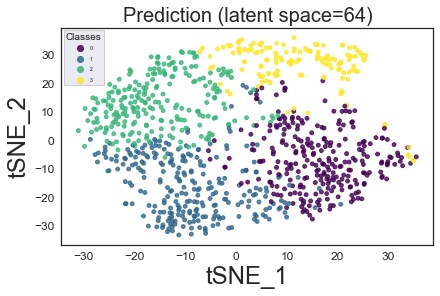

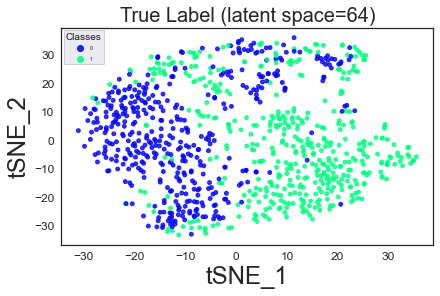


number of cells Wild =  436
number of Mutation cells  =  462
For label 0:
number of cells of the cluster: 270
Percentage of occurrences of wild cells: 8.89%
Percentage of occurrences of mutation cells: 91.11%
For label 1:
number of cells of the cluster: 257
Percentage of occurrences of wild cells: 71.60%
Percentage of occurrences of mutation cells: 28.40%
For label 2:
number of cells of the cluster: 235
Percentage of occurrences of wild cells: 69.79%
Percentage of occurrences of mutation cells: 30.21%
For label 3:
number of cells of the cluster: 136
Percentage of occurrences of wild cells: 47.06%
Percentage of occurrences of mutation cells: 52.94%


In [23]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 4
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")
pourcentage_cells(clustering_labels,y_test)


Samples of each cluster


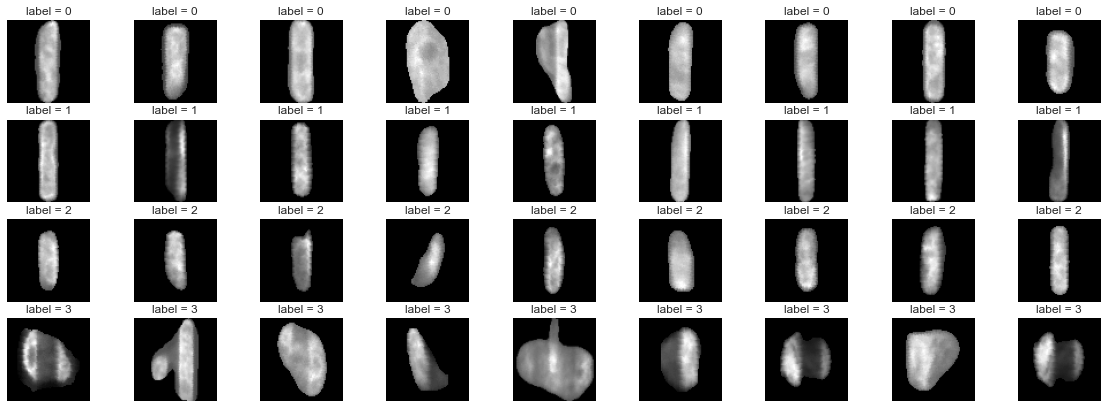

Silhouette: 0.1117, DB: 2.0815, CH: 125.8615


In [24]:
# Samples from each cluster
nb_samples = 9
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(20,7))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

s_16 = silhouette_score(z_test, clustering_labels)
db_16 = davies_bouldin_score(z_test, clustering_labels)
ch_16 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Silhouette: {s_16:.4f}, DB: {db_16:.4f}, CH: {ch_16:.4f}")

5 classes

<Figure size 432x288 with 0 Axes>

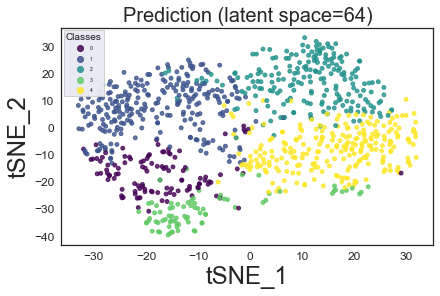

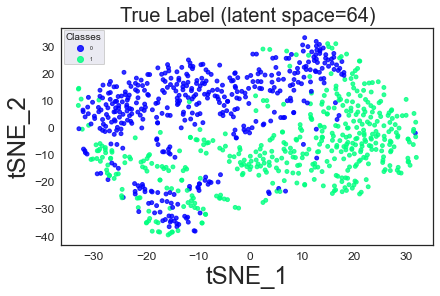


number of cells Wild =  436
number of Mutation cells  =  462
For label 0:
number of cells of the cluster: 111
Percentage of occurrences of wild cells: 45.05%
Percentage of occurrences of mutation cells: 54.95%
For label 1:
number of cells of the cluster: 257
Percentage of occurrences of wild cells: 83.27%
Percentage of occurrences of mutation cells: 16.73%
For label 2:
number of cells of the cluster: 209
Percentage of occurrences of wild cells: 58.37%
Percentage of occurrences of mutation cells: 41.63%
For label 3:
number of cells of the cluster: 80
Percentage of occurrences of wild cells: 37.50%
Percentage of occurrences of mutation cells: 62.50%
For label 4:
number of cells of the cluster: 241
Percentage of occurrences of wild cells: 8.30%
Percentage of occurrences of mutation cells: 91.70%


In [25]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 5
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")
pourcentage_cells(clustering_labels,y_test)

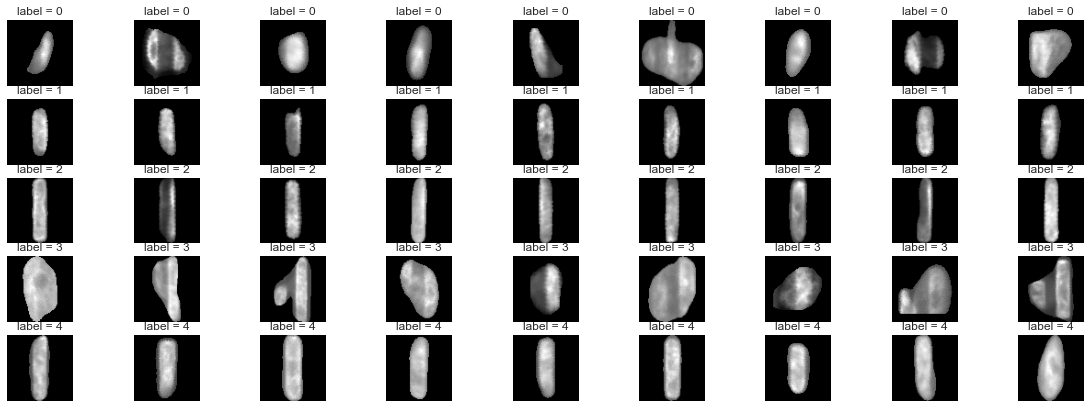

Silhouette: 0.1174, DB: 2.2549, CH: 107.3995


In [26]:
# Samples from each cluster
nb_samples = 9
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(20,7))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

s_16 = silhouette_score(z_test, clustering_labels)
db_16 = davies_bouldin_score(z_test, clustering_labels)
ch_16 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Silhouette: {s_16:.4f}, DB: {db_16:.4f}, CH: {ch_16:.4f}")

9 classes


<Figure size 432x288 with 0 Axes>

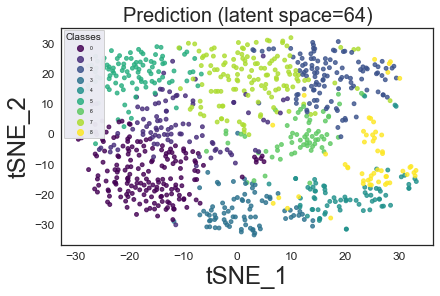

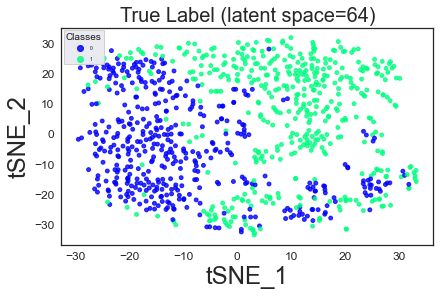


number of cells Wild =  436
number of Mutation cells  =  462
For label 0:
number of cells of the cluster: 180
Percentage of occurrences of wild cells: 93.33%
Percentage of occurrences of mutation cells: 6.67%
For label 1:
number of cells of the cluster: 93
Percentage of occurrences of wild cells: 81.72%
Percentage of occurrences of mutation cells: 18.28%
For label 2:
number of cells of the cluster: 113
Percentage of occurrences of wild cells: 0.88%
Percentage of occurrences of mutation cells: 99.12%
For label 3:
number of cells of the cluster: 80
Percentage of occurrences of wild cells: 40.00%
Percentage of occurrences of mutation cells: 60.00%
For label 4:
number of cells of the cluster: 73
Percentage of occurrences of wild cells: 45.21%
Percentage of occurrences of mutation cells: 54.79%
For label 5:
number of cells of the cluster: 104
Percentage of occurrences of wild cells: 71.15%
Percentage of occurrences of mutation cells: 28.85%
For label 6:
number of cells of the cluster: 65
P

In [27]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 9
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")
pourcentage_cells(clustering_labels,y_test)

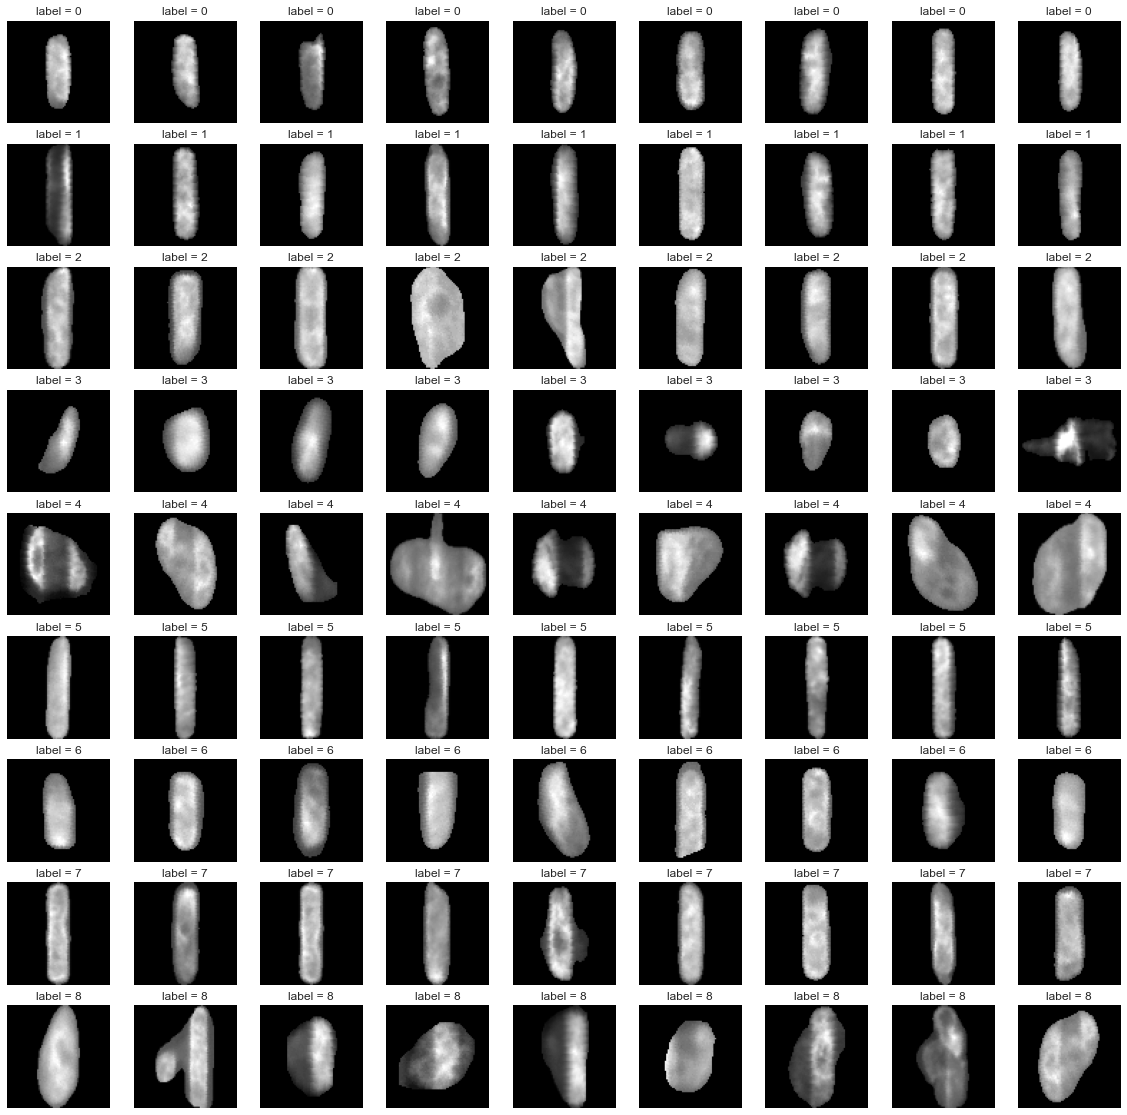

Silhouette: 0.0841, DB: 2.3412, CH: 73.3274


In [28]:
# Samples from each cluster
nb_samples = 9
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(20,20))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

s_16 = silhouette_score(z_test, clustering_labels)
db_16 = davies_bouldin_score(z_test, clustering_labels)
ch_16 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Silhouette: {s_16:.4f}, DB: {db_16:.4f}, CH: {ch_16:.4f}")